In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import math
import seaborn as sns
import os
# %config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

sc.settings.verbosity = 0
sc.logging.print_header()
sns.set_context("paper")

scanpy==1.6.0 anndata==0.7.4 umap==0.4.3 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.10.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.8.0


In [2]:
# import local module containing misc code, helps keep notebooks clean from commonly used functions
import sys
sys.path.insert(0, '../')
import new_misc_code as nmc

## **Load raw UMI count data**

In [3]:
# read in count matrices post nuclei and gene quality control
adata = sc.read( "../data/cleaned_count_matrices.h5ad")

In [4]:
# read in adata post clustering and dev-traj assignment
adata2 = sc.read_h5ad( "../data/post-gaba-wt-dev-traj.h5ad")

In [5]:
adata.obs_names.values

array(['AAACCTGAGAGTCGGT-RL1612_34d_v2', 'AAACCTGAGCCGCCTA-RL1612_34d_v2',
       'AAACCTGAGTCGAGTG-RL1612_34d_v2', ...,
       'TTTGTTGGTAAGGTCG-RL2132_25yr_v3',
       'TTTGTTGGTTCGGCTG-RL2132_25yr_v3',
       'TTTGTTGTCGTCCTCA-RL2132_25yr_v3'], dtype=object)

In [6]:
# add obs and obsm data to matching raw count nuclei
adata = adata[nmc.member_test( adata.obs_names.values, adata2.obs_names.values)]
adata.obs = adata2.obs
adata.obsm = adata2.obsm
adata.uns = adata2.uns
sc.pp.calculate_qc_metrics( adata, inplace=True)

In [7]:
# check if order of BCs match, should sum to 0
(adata.obs_names.values!=adata2.obs_names.values).sum()

0

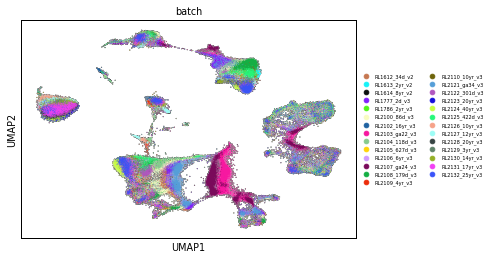

In [8]:
sc.pl.umap( adata, color=['batch'], legend_fontsize=5, add_outline=True, size=2, legend_fontoutline=0.5)

## **Clean up features a bit**

In [9]:
# change unknown NaNs in year collected to common date
adata.obs['Collection_year'].fillna( 9999, inplace=True)

In [10]:
# get list of batches
batches = adata.uns['batch_order']

## **Bulk by batch**

In [11]:
!mkdir ../data/limma-voom/

mkdir: cannot create directory ‘../data/limma-voom/’: File exists


In [17]:
# set minimum number of nuclei needed to make a bulk data set
min_cells = 10
# create dataframe to hold bulked data
batches = adata.uns['batch_order']
columns = [ ("--").join((x,y)) for x,y in zip( adata.var['gene_ids'].values, adata.var_names.values)]#
bulk = pd.DataFrame( index=batches, columns=columns)
# only want obs that are same across the batch, i.e. what can be controlled for
obs_col_mk = (adata.obs.nunique()<=len(batches)).values
obs_cols = np.array( adata.obs_keys())[obs_col_mk]
# drop all dev_traj observations
obs_cols = [ii for ii in obs_cols if 'traj' not in ii]
obs = pd.DataFrame(  index=batches, columns=obs_cols)
obs['Num_Cells'] = 0
# loop through batches
for batch_itr in batches:
    ind = batch_itr
    batch_mk = adata.obs['batch'].values==batch_itr
    num_cells = batch_mk.sum()
    if( min_cells<10):
        bulk.drop( ind, axis=0, inplace=True)
        obs.drop(  ind, axis=0, inplace=True)
        continue
    else:
        batch_adata = adata[batch_mk]
        bulk.loc[ind] = batch_adata.X.sum(0).A1
        obs.loc[ind,'Num_Cells'] = num_cells
        obs.loc[ind,obs_cols] = batch_adata.obs.iloc[0,obs_col_mk]

# save files
bulk.T.to_csv( f"../data/limma-voom/bulked-by-batch_pseudo-bulk-cts_min{min_cells}.csv")
obs.to_csv(  f"../data/limma-voom/bulked-by-batch_obs-cts_min{min_cells}.csv")

In [18]:
# example output, un-transposed
obs.head()

,batch,RL#,age,chem,concat_id,numerical_age,stage_id,Sex,Race,PMI,...,Oxygen/No Oxygen,Date-of-Collection,Collection_year,Library Prep Date,Library Prep Lot,mat/dev,cell_type,major_clust,downstream_dev_clusts,Num_Cells
RL2103_ga22_v3,RL2103_ga22_v3,RL2103,ga22,v3,7,-0.345205,Fetal,M,AA,5,...,Oxygen,nan,9999,28.03.2020,1,dev,PN,PN_dev,root,10466
RL2107_ga24_v3,RL2107_ga24_v3,RL2107,ga24,v3,11,-0.306849,Fetal,M,AA,9,...,No Oxygen,nan,9999,28.03.2020,1,dev,PN,L4_RORB,root,9376
RL2121_ga34_v3,RL2121_ga34_v3,RL2121,ga34,v3,15,-0.115068,Fetal,F,White,23,...,No Oxygen,11.01.2015,2015,16.04.2020,2,dev,PN,L4_RORB,root,6738
RL1777_2d_v3,RL1777_2d_v3,RL1777,2d,v3,3,0.00547945,Neonatal,F,White,26,...,Oxygen,7.22.2013,2013,27.06.2019,4,mat,PN,L5/6_TLE4,L5/6_TLE4_dev,9369
RL1612_34d_v2,RL1612_34d_v2,RL1612,34d,v2,0,0.0931507,Neonatal,M,AA,5,...,Oxygen,10.04.2011,2011,20.11.2018,5,dev,PN,L4_RORB,root,6533


In [19]:
# example output, un-transposed
bulk.head()

,ENSG00000243485--MIR1302-10,ENSG00000238009--RP11-34P13.7,ENSG00000237683--AL627309.1,ENSG00000239906--RP11-34P13.14,ENSG00000228463--AP006222.2,ENSG00000237094--RP4-669L17.10,ENSG00000236743--RP5-857K21.15,ENSG00000231709--RP5-857K21.1,ENSG00000235146--RP5-857K21.2,ENSG00000239664--RP5-857K21.3,...,ENSG00000237375--BX072566.1,ENSG00000215615--AL354822.1,ENSG00000215764--KIR2DL2,ENSG00000217792--KIR3DL2-1,ENSG00000268276--AL590523.1,ENSG00000215700--PNRC2-1,ENSG00000215699--SRSF10-1,ENSG00000215635--AC145205.1,ENSG00000251180--CU459201.1,ENSG00000215616--AC002321.2
RL2103_ga22_v3,2,33,7,5,718,359,0,0,19,0,...,2,32,1,0,1,33,571,25,4,1
RL2107_ga24_v3,0,24,11,1,668,394,1,0,5,2,...,1,448,2,0,4,44,246,46,10,3
RL2121_ga34_v3,0,24,6,1,166,1002,1,0,0,0,...,0,57,0,0,1,9,115,60,12,1
RL1777_2d_v3,1,42,32,12,741,656,3,1,14,0,...,1,514,0,0,1,101,1234,83,15,0
RL1612_34d_v2,1,16,5,0,298,264,0,0,0,1,...,1,29,2,0,0,5,185,2,5,0
